In [35]:
# Solo para omitir warnings, en general NO deberían usarlo
import warnings
warnings.filterwarnings("ignore")

#import pyfits #modulo para leer archivos fits
from astropy.io import fits
import matplotlib.pyplot as plt #modulo para graficar
import numpy as np #este modulo es para trabajar con matrices como en matlab
import scipy as sp
from scipy import ndimage
from astropy.stats import sigma_clip
from scipy.optimize import curve_fit
import pandas as pd 

In [2]:
cubo = fits.open("southgal_fixbadc.fits") #abrir objeto cubo de datos
data = cubo[0].data #extraer matriz de datos
header= cubo[0].header #extraer el header del archivo fits

In [3]:
# funcion para obtener los valores de los ejes l, b, v
def values(h,j):
    N=h['NAXIS'+str(j)];
    val=np.zeros(N)
    for i in range(0,N):
        val[i] = (i+1-float(h['CRPIX'+str(j)]))*float(h['CDELT'+str(j)]) + float(h['CRVAL'+str(j)])
    return val

#Estos seran los tres arreglos con los valores reales de los tres ejes del cubo
velocidad=values(header,1)
longitud=values(header,2)
latitud=values(header,3)

In [6]:
columns = ['longitud l', 'latitud b', 'v_tan']
tabla = pd.DataFrame(columns=columns)

for i_b in range(len(latitud)):
    for i_l in range(len(longitud)):
        T = data[i_b][i_l][:]
        r = sigma_clip(T, sigma_lower=3, sigma_upper=3)
        rms = np.sqrt(np.mean(r**2))
        rmask = r.mask
        if len(velocidad[rmask])==0:
            v_tan = np.nan
        else:
            v_tan = velocidad[rmask][0]
        
        tabla = tabla.append({'longitud l':longitud[i_l], 'latitud b':latitud[i_b], 'v_tan':v_tan}, ignore_index=True)

In [7]:
for lat in latitud:
    table_b_fix = tabla.loc[tabla['latitud b'] == lat]
    min_vel= table_b_fix['v_tan'].min()
    #print(lat, min_vel)

for lon in longitud:
    table_b_fix = tabla.loc[tabla['longitud l'] == lon]
    min_vel= table_b_fix['v_tan'].min()
    #print(lon, min_vel)

In [8]:
# Se crea una funcion que para una longitud(l) fija, se recorre latitud(b) y se calcula el rms de las
# velocidades
# Esta misma funcion recorre el cubo de las velocidades asociadas a l y b, hasta que se llega a una
# velocidad que es 5 veces mayor que el rms, esta ultima se guarda un arreglo

def fmin(l,latitud,vs):
    #recorre latitud
    for q in range(33):
        T1=data[q][l][:]
        rms=np.sqrt(np.mean(T1**2))   #calcula rms
        #recorre velocidad
        for w in range(306):
            if data[q][l][w]>=5*rms:  #buscamos que no sea ruido
                vs[q]=velocidad[w]    #guardamos la primera v donde T mayor a 5rms
                break

In [9]:
vmin=np.zeros(385)
bvmin=np.zeros(385)
R=np.zeros(385)
R0=8.5 #kPc
vsol=220

#maximorum
# Se recorren las longitudes y se busca la velocidad más negativa (mayor en modulo), se guarda esta
# y su latitud asociada
# Se obtiene un arreglo de R con la ecuacion R =| R0 · cos(l π/180 ) |

for i in range(385):
    vs=np.zeros(33)
    fmin(i,latitud,vs)
    v1=vs[0]
    b1=latitud[0]
    for j in range(32):
        if vs[j+1]<v1:
            v1=vs[j+1]
            b1=latitud[j+1]
    vmin[i]=v1
    bvmin[i]=b1
    R[i]=np.abs(R0*sp.sin(longitud[i]*sp.pi/180.)) #R0 sin(l)

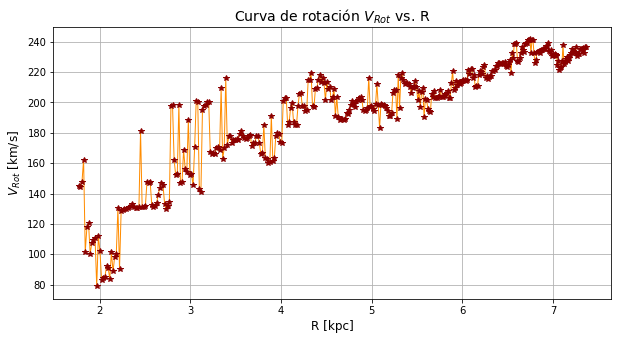

In [88]:
# Se obtiene la Vtan con Vtan = −Vmin − Vsol · sin(lπ/180 ), donde Vmin es la velocidad mayor en
# modulo para l, y Vsol es la velocidad de rotacion del sol.    
#velocidad de rotacion

vR=np.zeros(385)
for i in range(385):
    vR[i]= vmin[i]*(np.abs(sp.sin(longitud[i]*sp.pi/180.))/sp.sin(longitud[i]*sp.pi/180.)) + np.abs(vsol*sp.sin(longitud[i]*sp.pi/180.))

#curva de rotacion
plt.figure(figsize=(10, 5))
plt.clf
plt.plot(R,vR, linewidth = 1, color = 'darkorange')
plt.plot(R,vR, "*", color ='darkred')
plt.grid()
plt.title(r"Curva de rotación $V_{Rot}$ vs. R", fontsize='14')
plt.xlabel("R [kpc]", fontsize='12')
plt.ylabel(r"$V_{Rot}$ [km/s]", fontsize='12')
plt.savefig("curva_vr.png")
plt.show()


In [29]:
R_km = R * 3.086e+16
wR = vR / R_km

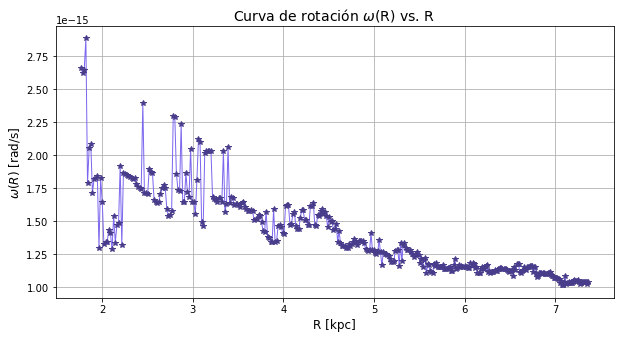

In [89]:
plt.figure(figsize=(10, 5))
plt.clf
plt.plot(R,wR, linewidth = 1, color = 'mediumslateblue')
plt.plot(R,wR, "*", color = 'darkslateblue')
plt.grid()
plt.title(r"Curva de rotación $\omega$(R) vs. R", fontsize='14')
plt.xlabel("R [kpc]", fontsize='12')
plt.ylabel(r"$\omega(R)$ [rad/s]", fontsize='12')
plt.savefig("curva_wr.png")
plt.show()

In [18]:
vmin = np.zeros(385)
bvmin = np.zeros(385)
R = np.zeros(385)
Z = np.zeros(385)
R0 = 8.5 #kPc
vsol = 220

#maximorum
# Se recorren las longitudes y se busca la velocidad más negativa (mayor en modulo), se guarda esta
# y su latitud asociada
# Se obtiene un arreglo de R con la ecuacion R =| R0 · cos(l π/180 ) |

for i in range(385):
    vs = np.zeros(33)
    fmin(i,latitud,vs)
    v1 = vs[0]
    b1 = latitud[0]
    for j in range(32):
        if vs[j+1]<v1:
            v1 = vs[j+1]
            b1 = latitud[j+1]
    vmin[i] = v1
    bvmin[i] = b1
    R[i] = np.abs(R0*np.sin(longitud[i]*np.pi/180.))#R0 sin(l)
    Z[i]= b1*np.pi/180*R0*np.cos(longitud[i]*np.pi/180.)
    

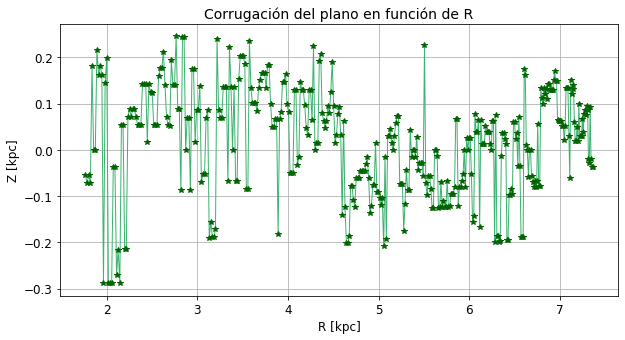

In [94]:
plt.figure(figsize=(10, 5))
plt.plot(R,Z, linewidth = 1, color = "mediumseagreen")
plt.plot(R,Z, "*", color = "darkgreen")
plt.grid()
plt.title("Corrugación del plano en función de R", fontsize = "14")
plt.xlabel("R [kpc]", fontsize='12')
plt.ylabel("Z [kpc]", fontsize='12')
plt.savefig("corrugacion.png")
plt.tick_params(labelsize='12')

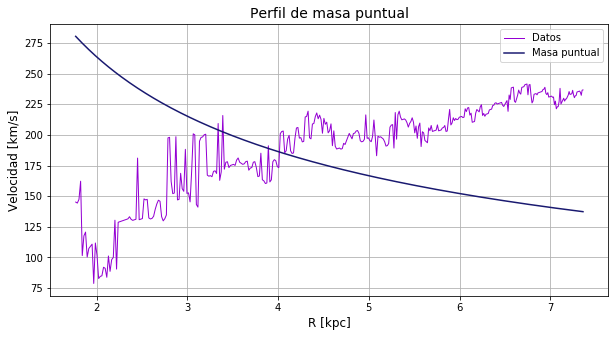

In [82]:
G=4.302e-6

# Masa Puntual 

def masapuntual(R,M0):
    M=M0
    v=sp.sqrt(G*M/R)
    return v

mpuntual,covmpuntual=curve_fit(masapuntual, R, vR)

plt.figure(figsize=(10, 5))
plt.title("Perfil de masa puntual", fontsize = 14)
plt.plot(R,vR, linewidth=1, color = "darkviolet",label='Datos')
plt.plot(R,masapuntual(R,mpuntual[0]),color = "midnightblue",label='Masa puntual')
plt.xlabel('R [kpc]', fontsize='12')
plt.ylabel('Velocidad [km/s]', fontsize='12')
plt.grid()
plt.legend()
plt.savefig("masapuntual.png")
 plt.show()

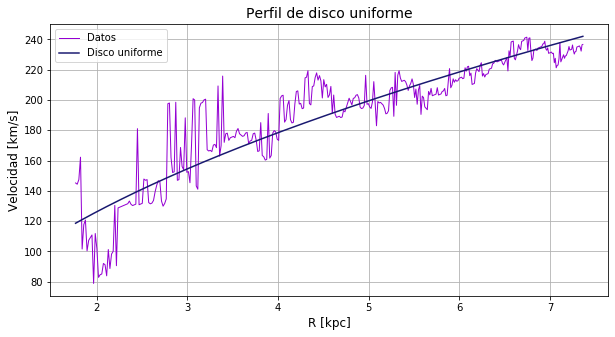

In [83]:
# Disco uniforme 

def discouniforme(R,S0):
    M=np.pi*(R**2)*S0
    v=sp.sqrt(G*M/R)
    return v

mpuntual,covmpuntual=curve_fit(discouniforme, R, vR)

plt.figure(figsize=(10, 5))
plt.title("Perfil de disco uniforme", fontsize = 14)
plt.plot(R,vR, linewidth=1, color = "darkviolet",label='Datos')
plt.plot(R,discouniforme(R,mpuntual[0]),color = "midnightblue",label='Disco uniforme')
plt.xlabel('R [kpc]', fontsize='12')
plt.ylabel('Velocidad [km/s]', fontsize='12')
plt.grid()
plt.legend()
plt.savefig("discou.png")
plt.show()

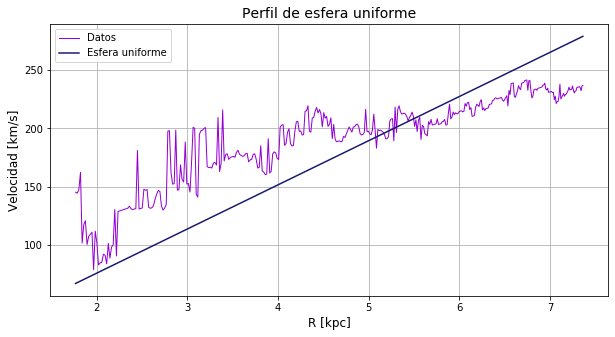

In [84]:
# Esfera uniforme
  
def esferauniforme(R,rho0):
    M=4/3*np.pi*(R**3)*rho0
    v=sp.sqrt(G*M/R)
    return v

mpuntual,covmpuntual=curve_fit(esferauniforme, R, vR)

plt.figure(figsize=(10, 5))
plt.title("Perfil de esfera uniforme", fontsize = 14)
plt.plot(R,vR,linewidth=1, color = "darkviolet",label='Datos')
plt.plot(R,esferauniforme(R,mpuntual[0]),color = "midnightblue",label='Esfera uniforme')
plt.xlabel('R [kpc]', fontsize='12')
plt.ylabel('Velocidad [km/s]', fontsize='12')
plt.grid()
plt.legend()
plt.savefig("esferau.png")
plt.show()

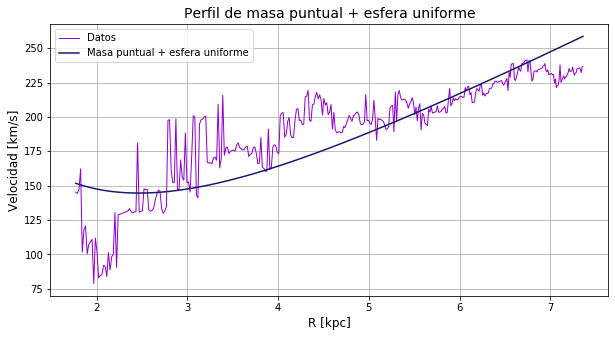

In [85]:
# Masa puntual + esfera uniforme

def masapuntual2(R,M0,rho0):
    M=M0+4/3*np.pi*(R**3)*rho0
    v=sp.sqrt(G*M/R)
    return v

mpuntual,covmpuntual=curve_fit(masapuntual2, R, vR)

plt.figure(figsize=(10, 5))
plt.title("Perfil de masa puntual + esfera uniforme", fontsize = 14)
plt.plot(R,vR, linewidth = 1, color = "darkviolet",label='Datos')
plt.plot(R,masapuntual2(R,mpuntual[0],mpuntual[1]),color = "midnightblue",label='Masa puntual + esfera uniforme')
plt.xlabel('R [kpc]', fontsize='12')
plt.ylabel('Velocidad [km/s]', fontsize='12')
plt.grid()
plt.legend()
plt.savefig("masaesfera.png")
plt.show()

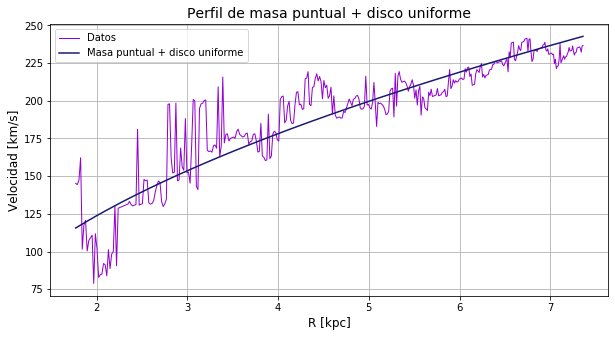

In [86]:
G=4.302e-6

# Masa puntual + disco uniforme

def masapuntual3(R,M0,S0):
    M=M0+np.pi*(R**2)*S0
    v=sp.sqrt(G*M/R)
    return v

mpuntual,covmpuntual=curve_fit(masapuntual3, R, vR)

plt.figure(figsize=(10, 5))
plt.title("Perfil de masa puntual + disco uniforme", fontsize = 14)
plt.plot(R,vR, linewidth = 1, color = "darkviolet",label='Datos')
plt.plot(R,masapuntual3(R,mpuntual[0],mpuntual[1]),color = "midnightblue",label='Masa puntual + disco uniforme')
plt.xlabel('R [kpc]', fontsize='12')
plt.ylabel('Velocidad [km/s]', fontsize='12')
plt.grid()
plt.legend()
plt.savefig("masadisco.png")
plt.show()